In [ ]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging
import seaborn as sns

from ignite.metrics import SSIM, PSNR




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF, GPVAE, GPVAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_ADNI, Encoder_ADNI_GPVAE, Decoder_ADNI, My_MaskedDataset
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


from matplotlib.patches import Rectangle

def plot_sequence(X, patches=None, edgecolor = 'c'):
    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(num_obs, num_seq))
    
    for i in range(num_seq):
        for j in range(num_obs):
            ax = plt.subplot(num_seq, num_obs, i * num_obs + j + 1)
            ax.imshow(X[i, j].transpose(1, 2, 0))
            ax.axis('off')
            
            # Add red contour if patches is not None and j is in patches
            if patches is not None and j in patches[i]:
                rect = Rectangle((0.1, 0.1), X[i, j].shape[2]+0.2, X[i, j].shape[1]+0.2, 
                                 linewidth=6, edgecolor=edgecolor, facecolor='none')
                ax.add_patch(rect)
    
    plt.show()
    logger.setLevel(old_level)



%reload_ext autoreload
%autoreload 2

!nvidia-smi

In [2]:
# Load the data
train_data = torch.load('ADNI_train.pt') #(N, T, D)
eval_data = torch.load('ADNI_eval.pt')
test_data = torch.load('ADNI_test.pt')
print(train_data.shape)

train_seq_mask = torch.load('ADNI_train_seq_mask.pt') #(N, T)
eval_seq_mask = torch.load('ADNI_eval_seq_mask.pt')
test_seq_mask = torch.load('ADNI_test_seq_mask.pt')


train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 8, 120])


In [3]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)


PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-09-15_13-56-13/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_0/checkpoints/epoch=49-step=1250.ckpt'


device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data[train_seq_mask == 1], verbose = True, T_multiplier=5, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 1
out_channels = 1
channels = 32
n_res_blocks = 2
attention_levels = [0]
channel_multipliers = [1]
n_heads = 2

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (1, 120)
f = 40 #subsampling factor
latent_dim = 1* (120 // f) * (120 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end, channels = 1)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4, channels = 1).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  0.0013091053115203977
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 9
Number of parameters in the diffusion model:  353953


In [4]:
model_config = LVAE_IAF_Config(
    input_dim=(1, 120),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_ADNI(model_config.input_dim, model_config.latent_dim).to(device)
decoder = Decoder_ADNI(model_config.input_dim, model_config.latent_dim).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 0.5)
temperature = 0.5


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                verbose = True, temp = temperature)


lvae = LVAE_IAF.load_from_folder('lldm/LVAE_IAF_training_2024-09-15_20-02-00/final_model').to(device)
gpvae = GPVAE.load_from_folder('dummy_output_dir/GPVAE_training_2024-09-16_11-49-49/final_model').to(device)

lldm.eval()
lvae.eval()
gpvae.eval()

Diffusion time steps  [995 853 711 569 427 285 143   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 2.0e+04
Number of total parameters: 4.0e+05


GPVAE(
  (decoder): Decoder_ADNI(
    (fc): Sequential(
      (0): Linear(in_features=9, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=30, bias=True)
      (3): ReLU()
      (4): Linear(in_features=30, out_features=60, bias=True)
      (5): ReLU()
      (6): Linear(in_features=60, out_features=120, bias=True)
      (7): ReLU()
    )
  )
  (encoder): Encoder_ADNI_GPVAE(
    (fc): Sequential(
      (0): Linear(in_features=120, out_features=60, bias=True)
      (1): ReLU()
      (2): Linear(in_features=60, out_features=30, bias=True)
      (3): ReLU()
      (4): Linear(in_features=30, out_features=15, bias=True)
      (5): ReLU()
    )
    (embedding): Linear(in_features=15, out_features=9, bias=True)
    (log_var): Linear(in_features=15, out_features=18, bias=True)
  )
)

In [5]:
import torchinfo
print(torchinfo.summary(unet, input_size=(1, 1, 3, 3), cond = None, time_steps = torch.tensor([10])))
print(torchinfo.summary(vae))
print(torchinfo.summary(lldm))
print(torchinfo.summary(lvae))
print(torchinfo.summary(gpvae))

Layer (type:depth-idx)                                       Output Shape              Param #
UNetModel                                                    [1, 1, 3, 3]              --
├─Sequential: 1-1                                            [1, 128]                  --
│    └─Linear: 2-1                                           [1, 128]                  (4,224)
│    └─SiLU: 2-2                                             [1, 128]                  --
│    └─Linear: 2-3                                           [1, 128]                  (16,512)
├─ModuleList: 1-2                                            --                        --
│    └─TimestepEmbedSequential: 2-4                          [1, 32, 3, 3]             --
│    │    └─Conv2d: 3-1                                      [1, 32, 3, 3]             (320)
│    └─TimestepEmbedSequential: 2-5                          [1, 32, 3, 3]             --
│    │    └─ResBlock: 3-2                                    [1, 32, 3, 3]       

In [5]:
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-09-15_15-36-55/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [6]:
def extract_train_embeddings(model, train_data, batch_size = 256):
    train_embeddings = [] 
    #log_vars = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False)
    for i, x in enumerate(train_loader):
        x = x.to('cuda')
        out = model.encoder(x)
        z = out.embedding.reshape(-1, model.n_obs, model.latent_dim)
        log_var = out.log_covariance
        train_embeddings.append(z.cpu().detach())
        #log_vars.append(log_var.cpu().detach())
    train_embeddings = torch.cat(train_embeddings, dim = 0)

    return train_embeddings


def plot_z_seqs(z_seq, train_embeddings):

    num_obs =  NUM_OBS =  train_embeddings.shape[1] 
    pca = PCA(n_components=2)
    n_samples = z_seq.shape[0]
    train_embeddings_pca = pca.fit_transform(train_embeddings.reshape(-1, latent_dim).cpu().detach().numpy()).reshape(-1, num_obs, 2)

    displayed_indexes = range(num_obs)  #range(num_obs)

    all_sequences = z_seq
    all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
    all_sequences_pca = all_sequences_pca.reshape(n_samples, -1, 2)
    plt.figure(figsize=(NUM_OBS, n_samples))
    plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
    colors = plt.get_cmap('tab10', num_obs)
    for i in displayed_indexes:
        plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Train obs. {i}')

    for i in range(n_samples):
        plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


    plt.legend()
    plt.show()


In [7]:
train_embeddings = extract_train_embeddings(lldm, train_data)
train_embeddings_lvae = extract_train_embeddings(lvae, train_data)

print(train_embeddings.shape)
print(train_embeddings_lvae.shape)

torch.Size([8000, 8, 9])
torch.Size([8000, 8, 9])


## Testing generation 
### (without freezing a given obs)

In [10]:
lldm.temperature = 0
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=5, vi_index =5, T_multiplier = 200, verbose = False)
plot_z_seqs(z_seq, torch.nan_to_num(train_embeddings))

NameError: name 'train_embeddings' is not defined

In [11]:
lldm.temperature = 1
generated_lldm, _ = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =5, T_multiplier = 200, verbose = False)
generated_lvae, _ = lvae.generate(random_normal = True, num_gen_seq=test_data.shape[0])
generated_gpvae = gpvae.generate(n_samples=test_data.shape[0], batch_size = 128)

Remainder batch size...: size 104


In [12]:
flat_test_data = test_data.reshape(-1, test_data.shape[2])
nan_indices = torch.isnan(flat_test_data).any(axis=1)
flat_test_data = flat_test_data[~nan_indices]

print(flat_test_data.shape)

generated_lldm = generated_lldm.reshape(-1, test_data.shape[2])
generated_lvae = generated_lvae.reshape(-1, test_data.shape[2])
generated_gpvae = generated_gpvae.reshape(-1, test_data.shape[2])




torch.Size([7100, 120])


In [23]:
def plot_correlation_matrix(data = None, corrmat = None):
    # Assuming your correlation matrix is torch.Tensor

    if corrmat == None:
        assert data is not None, "Please provide data to compute the correlation matrix"
        corrmat = torch.corrcoef(data.T)
        corrmat = torch.nan_to_num(corrmat)
    else:  
        corrmat = torch.nan_to_num(corrmat)

    # Convert torch Tensor to numpy array for plotting
    corr_matrix_np = corrmat.numpy()

    # Set figure size large enough to display a 120x120 matrix clearly
    plt.figure(figsize=(15, 12))

    # Plot heatmap without annotations to avoid cluttering
    sns.heatmap(corr_matrix_np, cmap="coolwarm", vmin=-1, vmax=1, 
                square=True, cbar_kws={"shrink": .75})

    # Optionally rotate x-axis labels for readability
    plt.xticks(rotation=90, fontsize=6)  # Reduce font size for large matrices
    plt.yticks(rotation=0, fontsize=6)   # Keep y-axis labels horizontal

    # Optional: Reorder the heatmap by clustering similar features together (if needed)
    # sns.clustermap(corr_matrix_np, cmap="coolwarm", vmin=-1, vmax=1)
    # Show plot
    plt.show()
    return corrmat


In [ ]:
print('---- TRUE CORRELATION MATRIX ----')
true_corrmat = plot_correlation_matrix(flat_test_data)

print('---- CORRELATION MATRIX LLDM ----')
lldm_corrmat = plot_correlation_matrix(generated_lldm)
diff_lldm_corrmat = plot_correlation_matrix(corrmat =  lldm_corrmat - true_corrmat)
print('L2 distance w.r.t. true correlation matrix:', torch.norm(true_corrmat - lldm_corrmat, p=2))
print('---- CORRELATION MATRIX LVAE ----')
lvae_corrmat = plot_correlation_matrix(generated_lvae)
print('L2 distance w.r.t. true correlation matrix:', torch.norm(true_corrmat - lvae_corrmat, p=2))
print('---- CORRELATION MATRIX GPVAE ----')
gpave_corrmat = plot_correlation_matrix(generated_gpvae)
print('L2 distance w.r.t. true correlation matrix:', torch.norm(true_corrmat - gpave_corrmat, p=2))


IDX FEATURES [44, 1, 22, 108, 46]


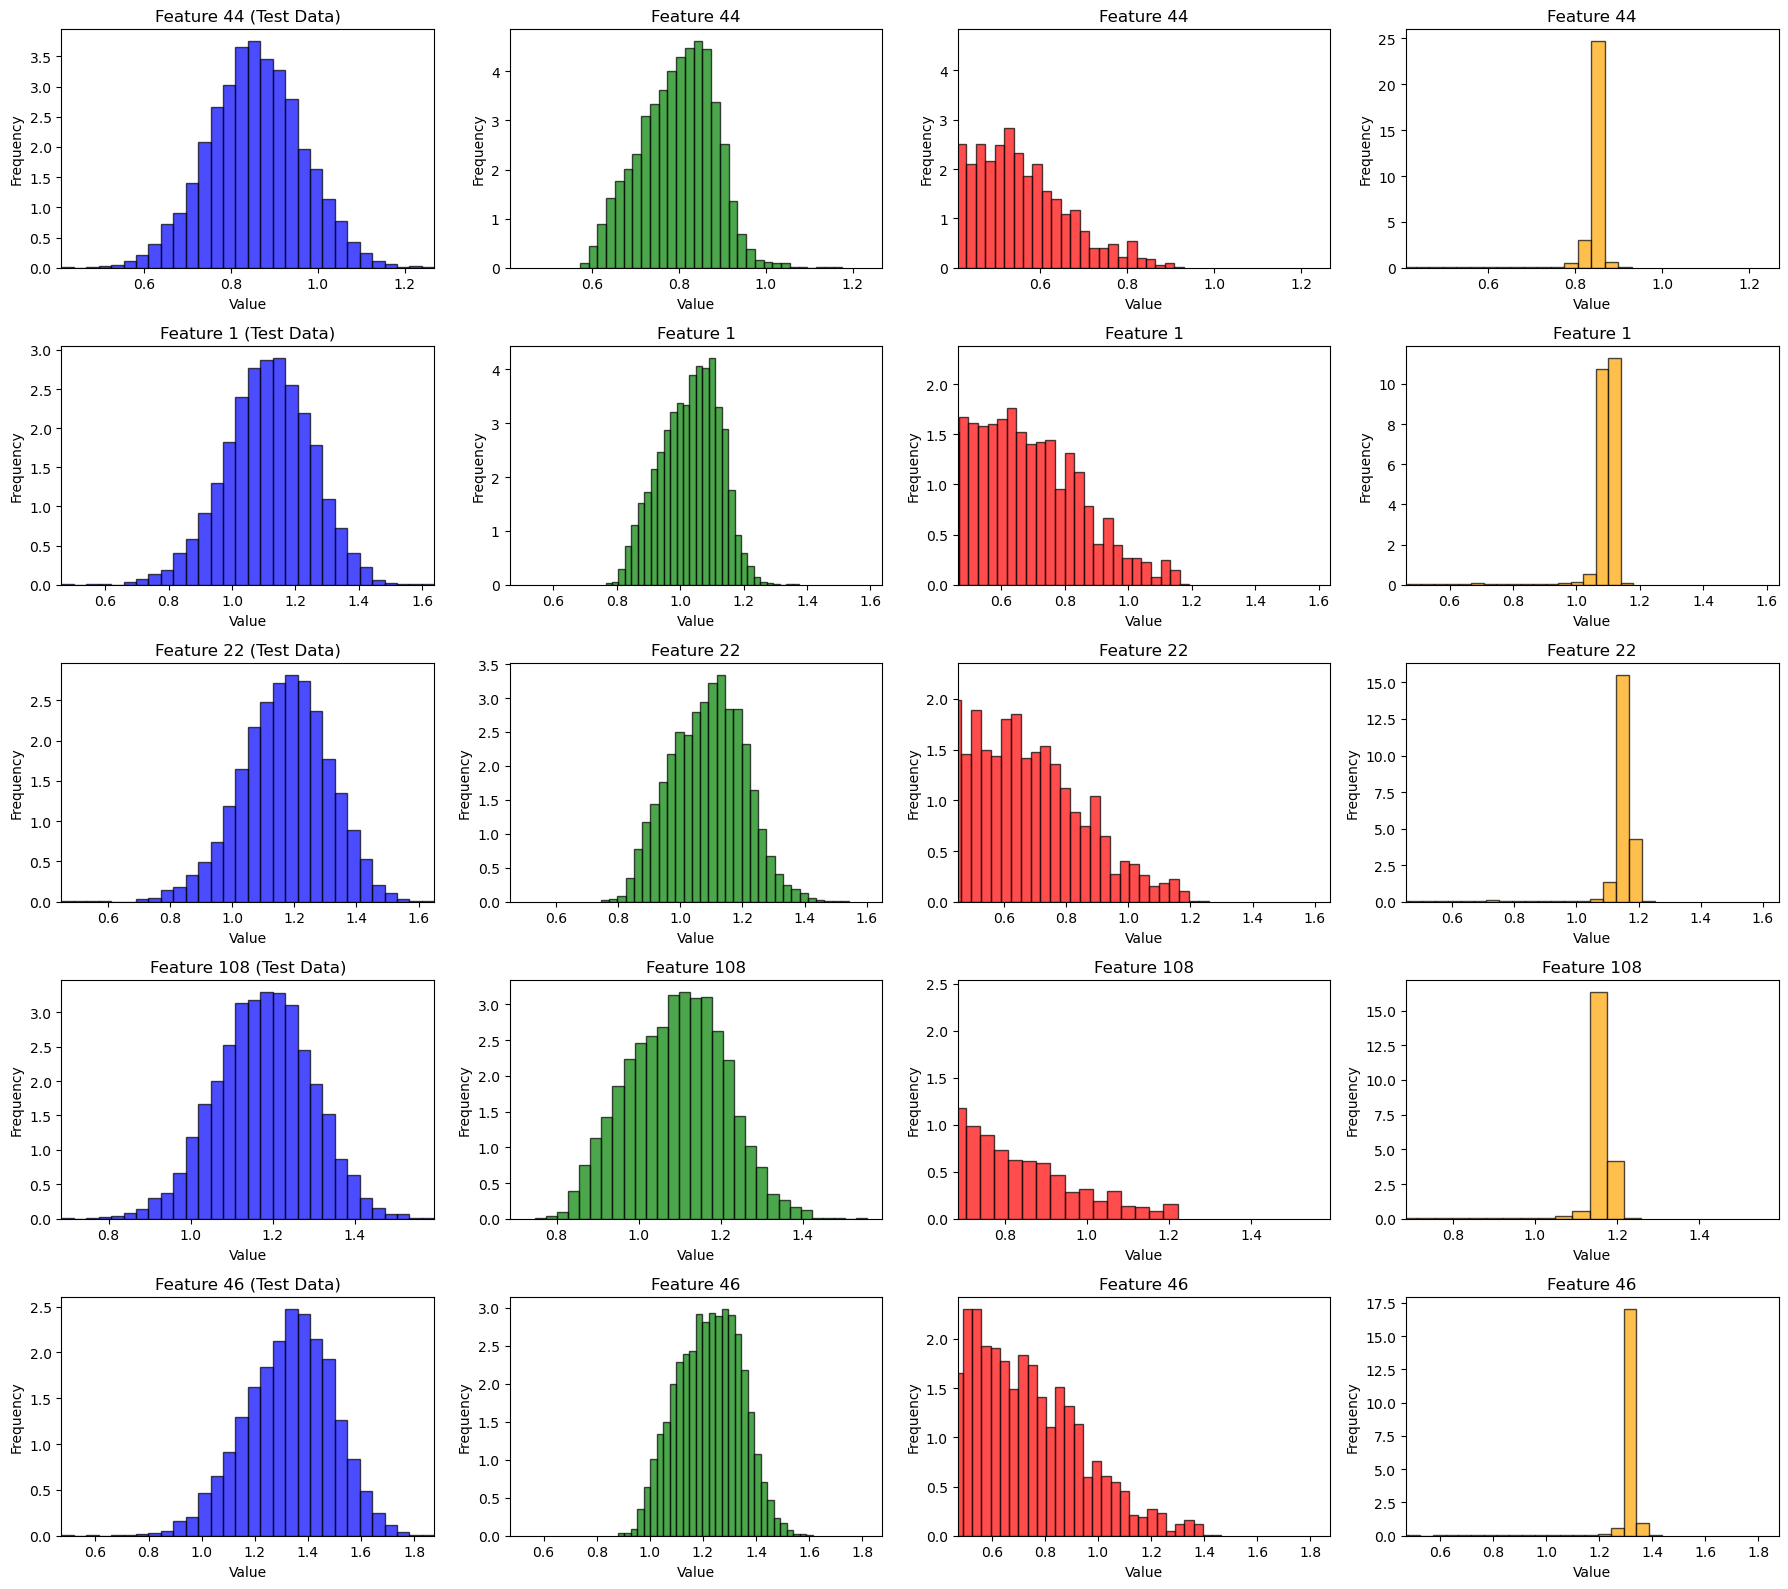

In [13]:
idx_features = [44, 1, 22, 108, 46]

print("IDX FEATURES", idx_features)

# Create a 5x4 subplot grid (5 features, each with 4 histograms)
fig, axes = plt.subplots(5, 4, figsize=(18, 16))  # Adjust the size for a large figure

# Loop through each feature index
for i, feature_idx in enumerate(idx_features):
    # Calculate the x-axis limits based on the true test data
    x_min, x_max = flat_test_data[:, feature_idx].min(), flat_test_data[:, feature_idx].max()
    
    # Plot histograms for each dataset in the corresponding subplot row
    for j, data in enumerate([flat_test_data, generated_lldm, generated_lvae, generated_gpvae]):
        # Select current axis
        ax = axes[i, j]
        
        # Plot histogram for the current feature from each dataset
        ax.hist(data[:, feature_idx], bins=30, color=['blue', 'green', 'red', 'orange'][j], 
                alpha=0.7, edgecolor='black', density=True)
        
        # Set x-axis limits to be the same across all histograms on this row (based on test data)
        ax.set_xlim(x_min, x_max)
        
        # Set title for each subplot (Feature number)
        if j == 0:
            ax.set_title(f'Feature {feature_idx} (Test Data)', fontsize=12)
        else:
            ax.set_title(f'Feature {feature_idx}', fontsize=12)
        
        # Set consistent x and y axis labels
        ax.set_xlabel('Value', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)


# Adjust layout for better spacing and avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.linalg import inv, det

def fit_gaussian(data):
    """
    Fit a Gaussian to the dataset by calculating the mean and covariance matrix.
    """
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def kl_divergence_gaussian(mu0, cov0, mu1, cov1, regularization=1e-1):
    """
    Compute the KL divergence between two multivariate Gaussians:
    p ~ N(mu0, cov0) and q ~ N(mu1, cov1).
    Regularize the covariance matrix to avoid singular matrix errors.
    """
    d = mu0.shape[0]  # Dimensionality

    # Regularization: Add small values to diagonal of covariance matrices to ensure they are invertible
    cov1 += np.eye(d) * regularization
    cov0 += np.eye(d) * regularization


    cov1_inv = inv(cov1)

    term1 = np.log(det(cov1) / det(cov0))
    term2 = np.trace(cov1_inv @ cov0)
    term3 = (mu1 - mu0).T @ cov1_inv @ (mu1 - mu0)

    kl_div = 0.5 * (term1 - d + term2 + term3)
    return kl_div

In [ ]:

# Assuming your actual data is already loaded
# Fit Gaussians
mu_test, cov_test = fit_gaussian(flat_test_data.numpy())
mu_lldm, cov_lldm = fit_gaussian(generated_lldm.numpy())
mu_lvae, cov_lvae = fit_gaussian(generated_lvae.numpy())
mu_gpvae, cov_gpvae = fit_gaussian(generated_gpvae.numpy())

# Compute KL Divergence using pre-existing KL formula
kl_lldm = kl_divergence_gaussian(mu_test, cov_test, mu_lldm, cov_lldm)
kl_lvae = kl_divergence_gaussian(mu_test, cov_test, mu_lvae, cov_lvae)
kl_gpvae = kl_divergence_gaussian(mu_test, cov_test, mu_gpvae, cov_gpvae)

# Print results
print(f"KL divergence (Test vs LLDM): {kl_lldm}")
print(f"KL divergence (Test vs LVAE): {kl_lvae}")
print(f"KL divergence (Test vs GPVAE): {kl_gpvae}")

#### Varying start_index

In [10]:
from tqdm import tqdm
lldm.temperature = 0
flat_test_data = test_data.reshape(-1, test_data.shape[2])
nan_indices = torch.isnan(flat_test_data).any(axis=1)
flat_test_data = flat_test_data[~nan_indices]
mu_test, cov_test = fit_gaussian(flat_test_data.numpy())

print(flat_test_data.shape)
all_scores_lldm = []
for i in tqdm(range(lldm.n_obs-2)): 
    generated_lldm, _ = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =i, T_multiplier = 200, verbose = False)
    generated_lldm = generated_lldm.reshape(-1, test_data.shape[2])
    mu_lldm, cov_lldm = fit_gaussian(generated_lldm.numpy())
    kl_lldm = kl_divergence_gaussian(mu_test, cov_test, mu_lldm, cov_lldm)
    print('-------------------')
    print("Index: ", i)
    print(f"KL divergence (Test vs LLDM): {kl_lldm}")
    all_scores_lldm.append(kl_lldm)


torch.Size([7100, 120])


 17%|█▋        | 1/6 [00:12<01:04, 12.92s/it]

-------------------
Index:  0
KL divergence (Test vs LLDM): 8.351588506728202


 33%|███▎      | 2/6 [00:26<00:53, 13.29s/it]

-------------------
Index:  1
KL divergence (Test vs LLDM): 29.323738689070375


 50%|█████     | 3/6 [00:39<00:39, 13.10s/it]

-------------------
Index:  2
KL divergence (Test vs LLDM): 65.3911298795401


 67%|██████▋   | 4/6 [00:52<00:26, 13.03s/it]

-------------------
Index:  3
KL divergence (Test vs LLDM): 107.88031875937071


 83%|████████▎ | 5/6 [01:05<00:12, 12.93s/it]

-------------------
Index:  4
KL divergence (Test vs LLDM): 154.0457662800423


100%|██████████| 6/6 [01:17<00:00, 12.95s/it]

-------------------
Index:  5
KL divergence (Test vs LLDM): 202.44549637937098


## Future prediction

In [7]:
#Only keep the sequences that have full 8 obs without nan

test_data_8 = test_data[test_seq_mask.sum(dim = 1) == 8]
test_data_7 = test_data[test_seq_mask.sum(dim = 1) == 7]
test_data_6 = test_data[test_seq_mask.sum(dim = 1) == 6]
print(test_data_8.shape, test_data_7.shape, test_data_6.shape)

torch.Size([400, 8, 120]) torch.Size([300, 8, 120]) torch.Size([300, 8, 120])


In [18]:
test_dataset_8 = My_MaskedDataset(test_data_8, test_seq_mask[test_seq_mask.sum(dim = 1) == 8], test_pix_mask[test_seq_mask.sum(dim = 1) == 8])
test_loader = torch.utils.data.DataLoader(test_dataset_8, batch_size=128, shuffle=False)


for idx in range(1, 8):
    mc = []
    for it in range(20):
        mses  = []
        for i, x in enumerate(test_loader):
            x = x.data.cuda()
            B, T, D = x.shape
            seq_mask = torch.ones_like(x)
            seq_mask[:, :-idx] = torch.zeros_like(seq_mask[:, :-idx])
            x = x * seq_mask
            encoder_output = gpvae.encoder(x)
            mu, log_var = encoder_output.embedding.reshape(x.shape[0], gpvae.time_length, -1), encoder_output.log_covariance.reshape(x.shape[0], gpvae.time_length, -1)
            qz_x = gpvae.posterior_dist(mean=mu, log_covar=log_var)
            z = qz_x.rsample()
            z = torch.transpose(z, 1, 2)
            pred_x = gpvae.decoder(z.reshape(-1, gpvae.latent_dim))["reconstruction"].reshape(B, T, D)
            mse = F.mse_loss(pred_x[:, -idx:], x[:,  -idx:], reduction="none").cpu().detach()
            mse = mse.sum(2)
            mse = mse.mean(0)
            mses.append(mse)

        mses = torch.stack(mses)
        mc.append(mses.mean(0))
    
    mc = torch.stack(mc)
    print(f'Mean index {idx}:', mc.mean(0).numpy())
    print(f'Std index {idx}:', mc.std(0).numpy())



Mean index 1: [16.824572]
Std index 1: [0.14697264]
Mean index 2: [16.662052 16.773748]
Std index 2: [0.08024473 0.10700111]
Mean index 3: [16.791557 16.669106 16.850897]
Std index 3: [0.11826378 0.10166697 0.16517012]
Mean index 4: [16.855703 16.81109  16.71521  16.76604 ]
Std index 4: [0.12364994 0.13154086 0.1474968  0.07786429]
Mean index 5: [17.216568 16.824177 16.888836 16.733377 16.726048]
Std index 5: [0.21980684 0.12420794 0.3194913  0.18443134 0.0369376 ]
Mean index 6: [17.042974 17.154306 16.794613 16.756336 16.654398 16.813808]
Std index 6: [0.09497052 0.1011598  0.07852709 0.09518442 0.06393987 0.14078154]
Mean index 7: [17.17709  17.09705  17.171595 16.869888 16.754856 16.712643 16.779268]
Std index 7: [0.1166032  0.13119234 0.10301715 0.15400364 0.10439084 0.11717053
 0.11646947]


In [11]:
from tqdm import tqdm
def compute_pred_metrics(lldm, num_iter = 5, test_data = test_data, idx_max = None):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

    all_res_mse = []

    if idx_max is None:
        idx_max = lldm.n_obs - 1

    for l in range(num_iter):
        res_mse = torch.zeros((lldm.n_obs-1, lldm.n_obs))
        for index in tqdm(reversed(range(idx_max))):
            mses = []
            for i, x in enumerate(test_loader):
                x = x.to('cuda')
                B, T, D = x.shape
                pred_x = lldm.predict(x, vi_index = index, num_gen_seq=1)
                pred_x = pred_x.detach().reshape(B, T-index-1, D)
                orig = x[:, -pred_x.shape[1]:].detach()
                mse = F.mse_loss(pred_x, orig, reduction="none")
                mse = mse.sum(2)
                mse = mse.mean(0)
                mses.append(mse)
            
            stack_mses = torch.stack(mses).mean(dim=0)
            res_mse[lldm.n_obs - 2 - index, (index+1):] = torch.stack(mses).mean(dim=0)

        all_res_mse.append(res_mse)

    print(torch.mean(torch.stack(all_res_mse), dim=0))

    if num_iter > 1:
        print(torch.std(torch.stack(all_res_mse), dim=0))

    return all_res_mse, pred_x


In [14]:
lldm.temperature = 1
print('LLDM')
mse_lldm, _ = compute_pred_metrics(lldm, num_iter = 5, test_data = test_data_8, idx_max = 7)
print('LVAE')
mse_lvae, predd = compute_pred_metrics(lvae, num_iter = 5, test_data = test_data_8, idx_max = 7)

LLDM


7it [00:01,  5.08it/s]
7it [00:01,  5.13it/s]
7it [00:01,  5.13it/s]
7it [00:01,  5.13it/s]
7it [00:01,  5.13it/s]


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.9089],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  5.0607, 10.7271],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  4.8098,  7.7021, 13.3962],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  4.7608,  6.8706,  9.5290, 14.0695],
        [ 0.0000,  0.0000,  0.0000,  4.8070,  6.2448,  7.7430,  9.7546, 13.3983],
        [ 0.0000,  0.0000,  4.9776,  6.0806,  6.9394,  8.0013,  9.4980, 12.1563],
        [ 0.0000,  5.1204,  5.7406,  6.3178,  6.8697,  7.5391,  8.5208, 10.1575]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0120],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0374, 0.0372],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0631, 0.1206, 0.1217],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0666, 0.1616, 0.1363, 0.1185],
        [0.0000, 0.0000, 0.0000, 0.0638, 0.1262, 0.1997, 0.1811, 0.1926],
        [0.0000, 0.0000, 0.0296, 0.0562, 0.2640, 0.3772

7it [00:00, 36.92it/s]
7it [00:00, 37.13it/s]
7it [00:00, 37.07it/s]
7it [00:00, 37.09it/s]
7it [00:00, 37.22it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 24.5242],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 22.5437, 56.0684],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 14.7772, 28.2243, 63.1413],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 14.4260, 14.3838, 28.4594, 66.4544],
        [ 0.0000,  0.0000,  0.0000, 15.2240, 14.6094, 14.6946, 29.4244, 69.0685],
        [ 0.0000,  0.0000, 15.2431, 15.2528, 14.6693, 14.8878, 30.3230, 68.9289],
        [ 0.0000, 14.2881, 14.3265, 14.2844, 13.9788, 14.1401, 28.0675, 66.0893]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
